In [ ]:
root = r"C:\Users\nampo\Downloads"

in_file	 = h5py.File(os.path.join(root,"ascad-variable.h5"), "r")
print(in_file.keys())

#Load profiling traces
X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.float64)
# Load profiling labels
Y_profiling = np.array(in_file['Profiling_traces/labels'], dtype = np.uint8)

# Load attacking traces
X_attack = np.array(in_file['Attack_traces/traces'], dtype=np.float64)
# Load attacking labels
Y_attack = np.array(in_file['Attack_traces/labels'], dtype = np.uint8)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_profiling, Y_profiling, test_size=0.3, random_state=42, shuffle=True)
y_train = tf.one_hot(y_train,depth = 256)
y_val = tf.one_hot(y_val,depth = 256)

In [ ]:
nb_classes = 256
input_shape = (None,1400)
initializer = tk.initializers.GlorotUniform()
MLPmodel = tk.models.Sequential()
MLPmodel.add(tkl.Dense(1028, activation=tk.layers.LeakyReLU(alpha=0.3),kernel_initializer=initializer))
MLPmodel.add(tkl.Dense(512, activation=tk.layers.LeakyReLU(alpha=0.3),kernel_initializer=initializer))
MLPmodel.add(tkl.Dense(nb_classes, activation='softmax',kernel_initializer=initializer))

MLPmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
MLPmodel.build(input_shape)
print(MLPmodel.summary())
MLPhistory = MLPmodel.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=256, validation_batch_size = 256)    

In [ ]:
plt.figure()
plt.plot(MLPhistory.history['loss'])
plt.plot(MLPhistory.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for accuracy
plt.plot(MLPhistory.history['categorical_accuracy'])
plt.plot(MLPhistory.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
MLPmodel.save(os.path.join(root,"MLPmodel.h5"))

In [ ]:
MLPmodel = tk.models.load_model(os.path.join(root,'MLPmodel.h5'))

In [ ]:
#Prediction using ranking

rank_of_secret_key = []

batch_size = 1024
attack_dataset = tf.data.Dataset.from_tensor_slices((test_plaintexts, test_traces))
attack_dataset = attack_dataset.batch(batch_size)

key_probabilities = np.zeros(256)
print(len(attack_dataset))
for pt, trace in tqdm(attack_dataset, total=len(attack_dataset)):
    # Extract the points of interest
    #feature_vector = trace[poi_indices]
    trace = trace[:,:,np.newaxis]
    feature_vector = MLPmodel.predict(trace)
    
    for i in range(feature_vector.shape[0]):
        # Compute the probabilities for each label
        label_probabilities = {label: feature_vector[i,label] for label in range(256)}

        # Update the key probabilities
        for k in range(256):
            key_probabilities[k] += label_probabilities[LEAKAGE_MODEL(pt[i], k)]

        # Get the rank of the secret key
        rank_of_secret_key.append(np.count_nonzero(key_probabilities > key_probabilities[SECRET_KEY]))

plt.plot(rank_of_secret_key)
plt.title(f"Rank of the secret key ({SECRET_KEY:#04x})")
plt.show()

In [ ]:
first = np.where(np.array(rank_of_secret_key) == 0)
print(first)

In [ ]:
#print(first[0][0])
#plt.plot(rank_of_secret_key[:first[0][0]*2m])
plt.plot(rank_of_secret_key)
plt.ylabel("Rank of true key")
plt.xlabel("Number of traces")
plt.title("Rank of true secret key using simple MLP")
#plt.scatter(first[0][0],rank_of_secret_key[first[0][0]], c="red")

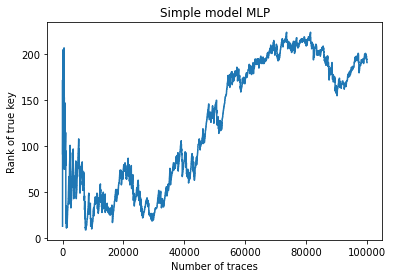